# SHAPE enabled-RNA-RNA interaction prediction

In [1]:
TAIR_genome = '/home/milad/1DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.fna'
TAIR_gff_NCBI = "/home/milad/1DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.gff.gz"
TAIR_gff_ensm = "/home/milad/1DataBase/TAIR/Arabidopsis_thaliana.TAIR10.38.gff3.gz"
TAIR_gff = TAIR_gff_NCBI

import os
import pandas as pd
from subprocess import Popen, PIPE

INTARNA_ARGS = "-n 20 --outOverlap=B --outMode=C --seedBP=4 --temperature 22  --qAccW 200 --qAccL 200 "
PATH_INTARNA = './IntaRNA/src/bin/'
INTARNA_BIN = os.path.join(PATH_INTARNA, 'IntaRNA') 

## Run plfold on query RNA U1

In [2]:
query_id = "ENSRNA049495626-T1-U1"
query_fasta = '../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa'
query_react = '../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.react'
query_react_idless = '../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.noid.react'


In [3]:
!head $query_react_idless

1	NA
2	7.0
3	7.0
4	0.0
5	NA
6	NA
7	0.0
8	7.0
9	3.389
10	NA


## Run IntaRNA

In [4]:
def run_intaRNA_precomputed_access(query_fa, target_fa, query_id, target_id, acc_lunp=None, out_suffix=''):

    # Make a shell command line
    subopt_csv = 'intarna-subopts_{}-{}{}.csv'.format(target_id, query_id, out_suffix)
    heatmap_csv = 'intarna-heatmap_{}-{}{}.csv'.format(target_id, query_id, out_suffix)
    cmd = 'IntaRNA --target={} --query={} '.format(target_fa, query_fa)
    cmd += '--out=pMinE:{} --out={} '.format(heatmap_csv, subopt_csv)
    params = '{} '.format(INTARNA_ARGS)
    if acc_lunp is not None:
        cmd += '--qAccFile={} '.format(lunp_shape)
        params += '--qAcc=P '
    
    print (cmd, params)
    p = Popen(cmd + params , stdin=PIPE, shell=True, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    if err or b"ERROR" in out:
        raise RuntimeError("Error in calling remuRNA\n{}\n{}\n".format(out, err))

    print (out)
    df_subopts = pd.read_csv(subopt_csv,sep=';')
    df_heatmap = pd.read_csv(heatmap_csv,sep=';')

    #df_subopts['intarna_params:{}'.format(params)] = ''
    return  df_subopts, df_heatmap

In [5]:
%matplotlib inline
import seaborn as sns
import pandas as pd


from matplotlib import pyplot as plt
def plot_minE_heatmap(df, exon_regions, figtitle, fig=None, ax=None):
    savefig = False
    if (fig is None):
        savefig = True
        fig, ax = plt.subplots(figsize=[50,5])
    mydf = df.iloc[:,1:]#.transpose()
    # mydf[mydf>0] = 'NaN'
    mydf[mydf>0] = None
    [ax.axvspan(ex[0]-1,ex[1]-1, alpha=0.2) for ex in exon_regions]

    sns.heatmap(mydf.transpose(),ax=ax)
    ax.set_ylim(ax.get_ylim()[1],ax.get_ylim()[0])

    import matplotlib.ticker as plticker
    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=100,))
    ax.yaxis.set_major_locator(plticker.MultipleLocator(base=10,))
    majorFormatter = plticker.FormatStrFormatter('%d')
    ax.xaxis.set_major_formatter(majorFormatter)
    ax.yaxis.set_major_formatter(majorFormatter)
    ax.set_title(figtitle)
    if savefig:
        fig.savefig(figtitle+'.png')
    # sns.heatmap(df_SHAPE.iloc[:,1:5],ax=ax)
    

## Extract exon junctions of single gene from gff file

In [6]:
import subprocess

def gene_gff_to_df(gene_name):
    gene_gff = gene_name+'.gff'
    gzip_cmd = "gunzip -c {} | grep 'gene={};' > {}".format(TAIR_gff, gene_name, gene_gff)
    print(gzip_cmd)
    subprocess.call(gzip_cmd, shell=True)

    df_gff = pd.read_csv(gene_gff, sep='\t',header=None,comment="#",
                     names=['seqname','source','feature','start','end','score','strand','frame','attribute'])


    df_genes = df_gff[df_gff['feature']=='gene']
    if len(df_genes) > 1:
        print ("BIG WARNING: multiple isoforms(?) found & IGNORED for gene", gene_name)
        print ("Genes with same name (isoforms?)")
    print (df_genes.iloc[:,0:7])
    df_gff_exons = df_gff[df_gff['feature']=='exon'].sort_values('start')
    df_gff_exons_uniqs = df_gff_exons.drop_duplicates(subset=['start','end']).copy()
    return df_gff_exons_uniqs, df_genes.iloc[0:1]


In [7]:
def df_gff_to_bed_fasta(df, gene_name):
    bed_df = df['seqname'].map(str) + '\t' + df['start'].map(str) + '\t' +\
        df['end'].map(str) + '\t' +\
        gene_name+'-'+df.index.map(str) + '\t' +\
        '1\t' + df['strand'].map(str)
    bed_str = '\n'.join(bed_df.values)
    print(bed_str)
    bed_file = gene_name+'.bed'
    fasta_genes_genomic = gene_name + '-genomic.fa'
    with open(bed_file, 'w') as bed_out:
        bed_out.write(bed_str)
    bed_cmd = 'bedtools getfasta -fi {} -bed {} -fo {} -s -name'.format(
        TAIR_genome, bed_file, fasta_genes_genomic)
    p = Popen(bed_cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    print(bed_cmd)
    if (err):
        raise RuntimeError('Error in bedtools\n{}\n{}'.format(out, err))
    print (out)
    print ('bedtools getfasta on ', fasta_genes_genomic)
    return fasta_genes_genomic

In [8]:
def compute_relative_locs(df_gff, gene_start, gene_end, strand):
    if (strand == '+'):
        df_gff.loc[:,'relative-start']= df_gff['start'] - gene_start+1
        df_gff.loc[:,'relative-end'] =  df_gff['end'] - gene_start+1
        ret_arr = [(r['relative-start'],r['relative-end']) for ir, r in df_gff.iterrows()]        
        
    elif (strand == '-'):
        df_gff.loc[:,'relative-start']= -df_gff['start'] + gene_end+1
        df_gff.loc[:,'relative-end'] =  -df_gff['end'] + gene_end+1
        ret_arr = [(r['relative-end'],r['relative-start']) for ir, r in df_gff.iterrows()]        
    else:
        raise RuntimeError('Strand type error')
    return ret_arr 



In [44]:
import math
import numpy as np
def parse_spotprobs(file1, file2, suffixes=['_STD','_SHAPE']):
    print("parse_spotprobs")
    df1 = pd.read_csv(file1,sep=';')
    df2 = pd.read_csv(file2,sep=';')
    df12 = pd.merge(df1, df2, on='spot', suffixes=suffixes)
    print(df12.info())
    df12['probability_SHAPE/probability_STD'] = (df12['probability_SHAPE']+1e-15)/(df12['probability_STD']+1e-15)
    df12['log10(probability_SHAPE/probability_STD)'] = np.log10(df12['probability_SHAPE/probability_STD'])
    return df12
def plot_spotprobs(file1, file2):
    print("plot_spotprobs")
    dfspotprobs = parse_spotprobs(file1, file2)
    
    dfmelt = pd.melt(dfspotprobs,  id_vars =['spot'], value_vars=['probability_STD','probability_SHAPE'])
    fig, (ax1,ax2) = plt.subplots(figsize=[12,4],ncols=2)
    sns.barplot(data=dfmelt, x='spot',y='value',hue='variable',ax=ax1)
    ax1.set_yscale('log')
    ax1.set_title(file1)
    
    sns.barplot(data=dfspotprobs, x='spot',color='b',y='log10(probability_SHAPE/probability_STD)')
    
    
spotprobs_file1 = 'intarna-spotProbs_ACT1-ENSRNA049495626-T1-U1.csv'
spotprobs_file2 = 'intarna-spotProbs_ACT1-ENSRNA049495626-T1-U1_INTARNASHAPE_.csv'

plot_spotprobs(spotprobs_file1, spotprobs_file2)


plot_spotprobs
parse_spotprobs


EmptyDataError: No columns to parse from file

In [45]:
def run_intaRNA_shape(query_fa, target_fa, query_id, target_id, shape_file=None, out_suffix='',
                      spot_probs_pairs_str=None):

    # Make a shell command line
    subopt_csv = 'intarna-subopts_{}-{}{}.csv'.format(target_id, query_id, out_suffix)
    heatmap_csv = 'intarna-heatmap_{}-{}{}.csv'.format(target_id, query_id, out_suffix)
    spotprob_csv = 'intarna-spotProbs_{}-{}{}.csv'.format(target_id, query_id, out_suffix)

    cmd = INTARNA_BIN + ' --target={} --query={} '.format(target_fa, query_fa)
    cmd += '--out=pMinE:{} --out={} '.format(heatmap_csv, subopt_csv)
    params = '{} '.format(INTARNA_ARGS)
    
    if shape_file is not None:
        cmd += '--qShape {} '.format(shape_file)
        params += '--qShapeMethod "Z" '
    if spot_probs_pairs_str is not None:
        cmd += '--out="spotProb:{}:{}" '.format(spot_probs_pairs_str, spotprob_csv)
    print (cmd, params)
    p = Popen(cmd + params , stdin=PIPE, shell=True, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    if err or b"ERROR" in out:
        raise RuntimeError("Error in calling remuRNA\n{}\n{}\n".format(out, err))

    print (out)
    df_subopts = pd.read_csv(subopt_csv,sep=';')
    df_heatmap = pd.read_csv(heatmap_csv,sep=';')

    #df_subopts['intarna_params:{}'.format(params)] = ''
    return  df_subopts, df_heatmap, spotprob_csv


def run_intarna_shape_for_a_gene(target_gene_name):
    df_gff_exons, df_genes = gene_gff_to_df(target_gene_name)
    fasta_bed_genomic = df_gff_to_bed_fasta(df_genes, target_gene_name)
    myexon_regions = compute_relative_locs(df_gff_exons, df_genes.iloc[0]['start'], df_genes.iloc[0]['end'],
                      df_genes.iloc[0]['strand'])
    print(myexon_regions)
    uniq_exon_ends = sorted(list(set([ex[1] for ex in myexon_regions])))
    uniq_exon_ends = uniq_exon_ends[:-1] # mRNA end is not considered
    spot_prob_locs = ["{}&8".format(exend+1) for exend in uniq_exon_ends] # Extract exon 3'end
    target_fasta = fasta_bed_genomic #'../data/RPS9/RPS9-genomic.fasta'
    
    mydf_subopts, mydf_heatmap, file_subopts = run_intaRNA_shape(query_fasta, target_fasta, query_id, target_gene_name, 
                                                               spot_probs_pairs_str=','.join(spot_prob_locs))
    mydf_subopts_SHAPE, mydf_heatmap_SHAPE, file_subopts_SHAPE = run_intaRNA_shape(query_fasta, target_fasta, query_id, target_gene_name, 
            shape_file=query_react_idless, out_suffix='_INTARNASHAPE_', 
                                                               spot_probs_pairs_str=','.join(spot_prob_locs))

    myfig, (ax1,ax2) = plt.subplots(figsize=[50,10],nrows=2)
    plot_minE_heatmap(mydf_heatmap, myexon_regions, target_gene_name +'-'+query_id+ '-NOSHAPE', fig=myfig, ax=ax1)
    plot_minE_heatmap(mydf_heatmap_SHAPE, myexon_regions,target_gene_name + '-'+query_id+'-SHAPE', fig=myfig, ax=ax2)
    myfig.suptitle('IntARNA-SHAPE')
    myfig.savefig('heatmap_'+target_gene_name +'-'+query_id+'.png')
    
    plot_spotprobs(file_subopts, file_subopts_SHAPE)

gunzip -c /home/milad/1DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.gff.gz | grep 'gene=ACT1;' > ACT1.gff
       seqname  source feature     start       end score strand
0  NC_003071.7  RefSeq    gene  15778941  15781561     .      +
NC_003071.7	15778941	15781561	ACT1-0	1	+
bedtools getfasta -fi /home/milad/1DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.fna -bed ACT1.bed -fo ACT1-genomic.fa -s -name
b''
bedtools getfasta on  ACT1-genomic.fa
[(1, 387), (244, 387), (294, 549), (811, 880), (815, 880), (1017, 1410), (1511, 2124), (2236, 2621)]
./IntaRNA/src/bin/IntaRNA --target=ACT1-genomic.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_ACT1-ENSRNA049495626-T1-U1.csv --out=intarna-subopts_ACT1-ENSRNA049495626-T1-U1.csv --out="spotProb:388&8,550&8,881&8,1411&8,2125&8:intarna-spotProbs_ACT1-ENSRNA049495626-T1-U1.csv"  -n 20 --outOverlap=B --outMode=C --seedBP=4 --temperature 22  --qAccW 200 --qAccL 200  
b''
./IntaRNA/src/bin/IntaRNA -

/home/milad/miniconda3/envs/intaSHAPE/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


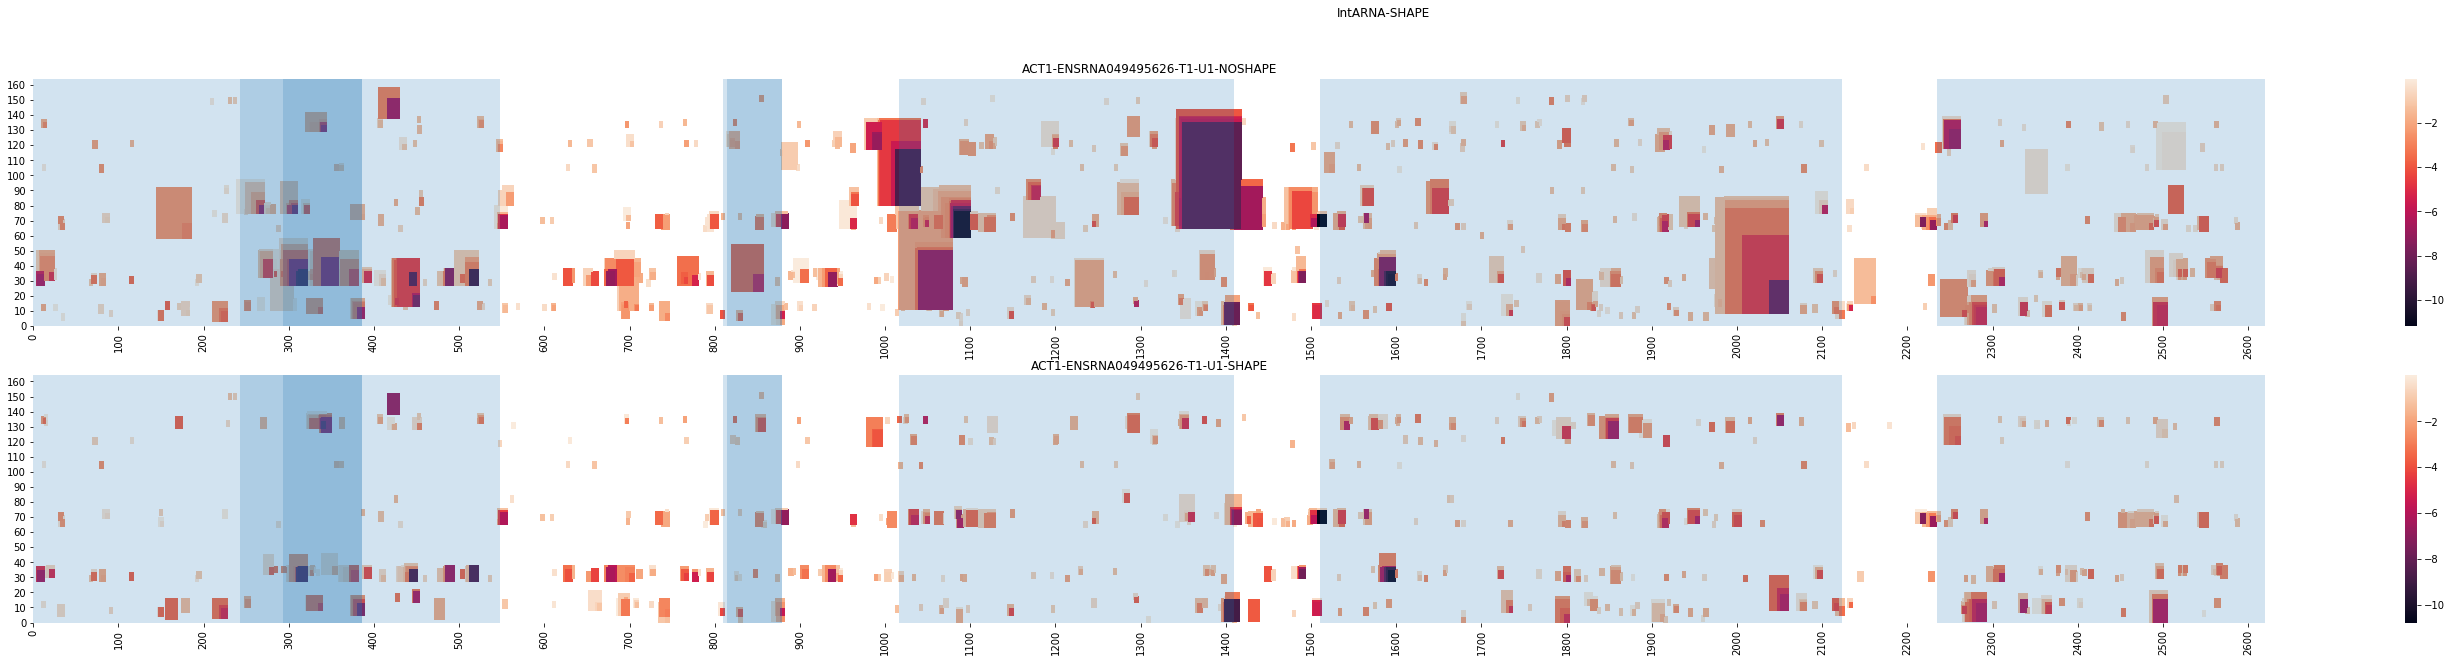

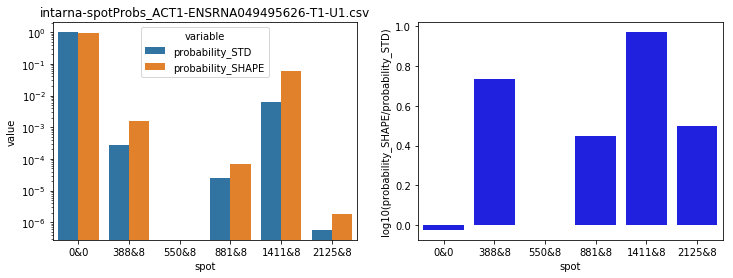

In [46]:
for gene in ['ACT1']:#, 'RPS9', 'RPS10','RPL16A','NBR1',]:#'rps11','RPS11B',:
    run_intarna_shape_for_a_gene(gene)

    

gunzip -c /home/milad/1DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.gff.gz | grep 'gene=ACT1;' > ACT1.gff
       seqname  source feature     start       end score strand
0  NC_003071.7  RefSeq    gene  15778941  15781561     .      +
NC_003071.7	15778941	15781561	ACT1-0	1	+
bedtools getfasta -fi /home/milad/1DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.fna -bed ACT1.bed -fo ACT1-genomic.fa -s -name
b''
bedtools getfasta on  ACT1-genomic.fa
[(1, 387), (244, 387), (294, 549), (811, 880), (815, 880), (1017, 1410), (1511, 2124), (2236, 2621)]
./IntaRNA/src/bin/IntaRNA --target=ACT1-genomic.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_ACT1-ENSRNA049495626-T1-U1.csv --out=intarna-subopts_ACT1-ENSRNA049495626-T1-U1.csv --out="spotProb:388&8,550&8,881&8,1411&8,2125&8:intarna-spotProbs_ACT1-ENSRNA049495626-T1-U1.csv"  -n 20 --outOverlap=B --outMode=C --seedBP=4 --temperature 22  --qAccW 200 --qAccL 200  
b''
./IntaRNA/src/bin/IntaRNA -

b''
plot_spotprobs
parse_spotprobs
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 0 to 6
Data columns (total 3 columns):
spot                 7 non-null object
probability_STD      7 non-null float64
probability_SHAPE    7 non-null float64
dtypes: float64(2), object(1)
memory usage: 224.0+ bytes
None


/home/milad/miniconda3/envs/intaSHAPE/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


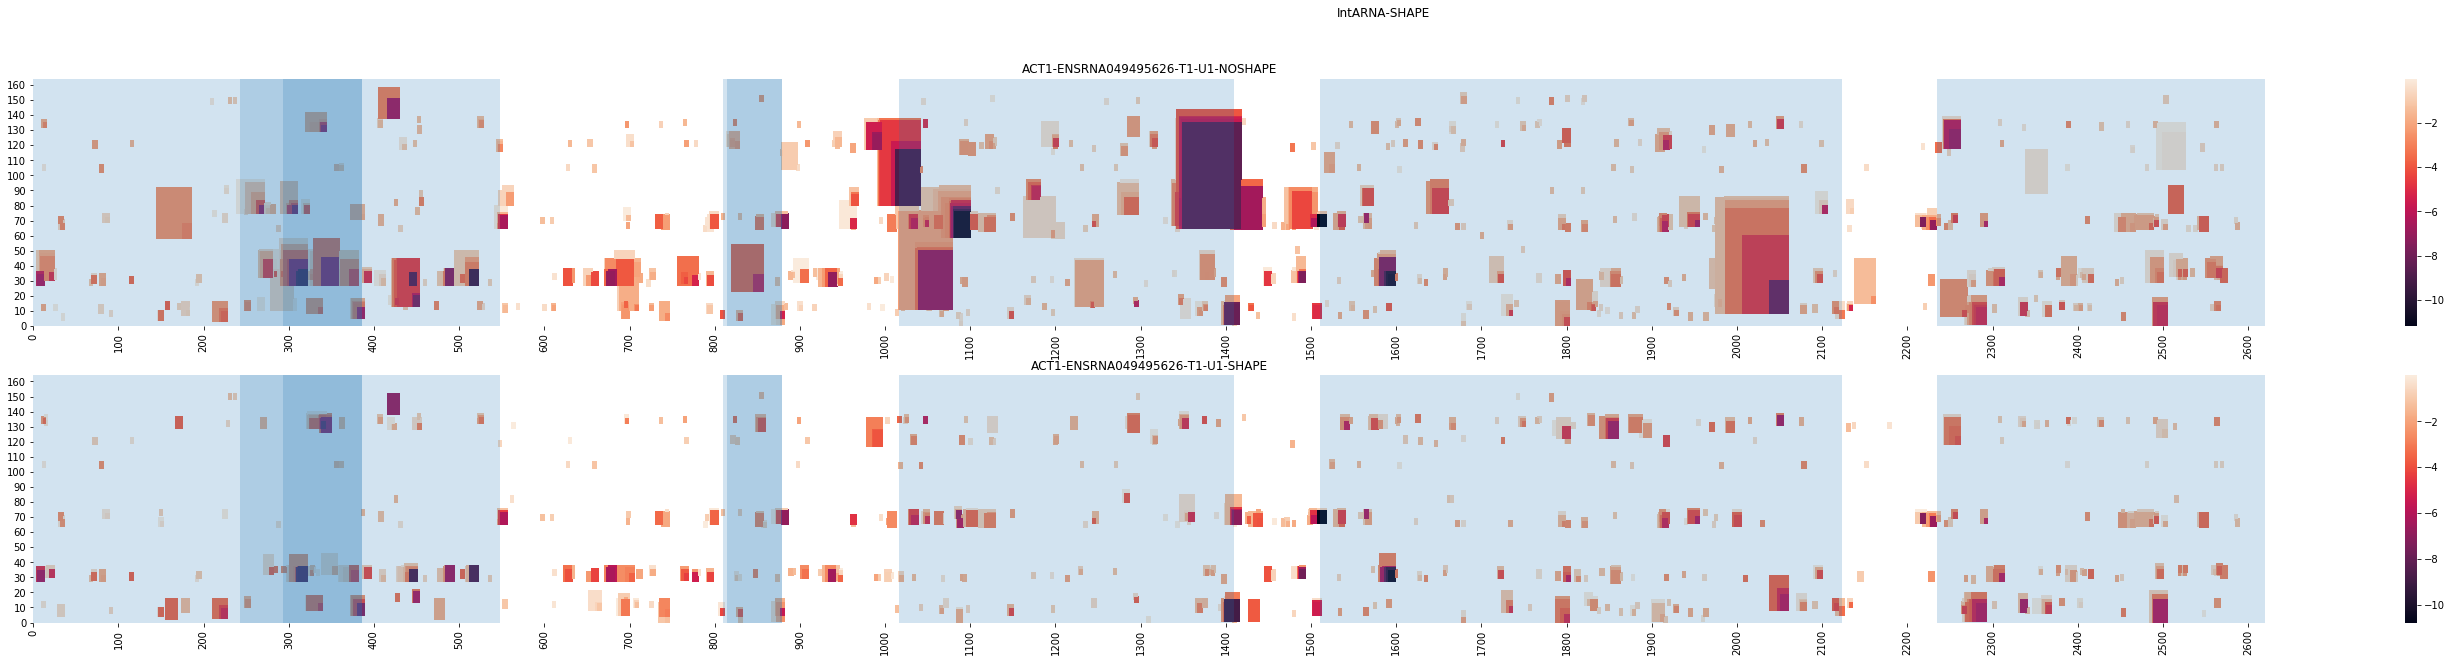

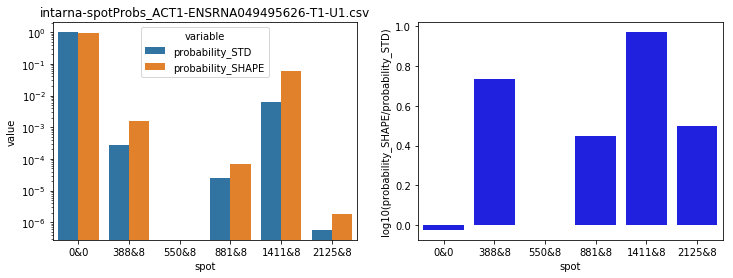

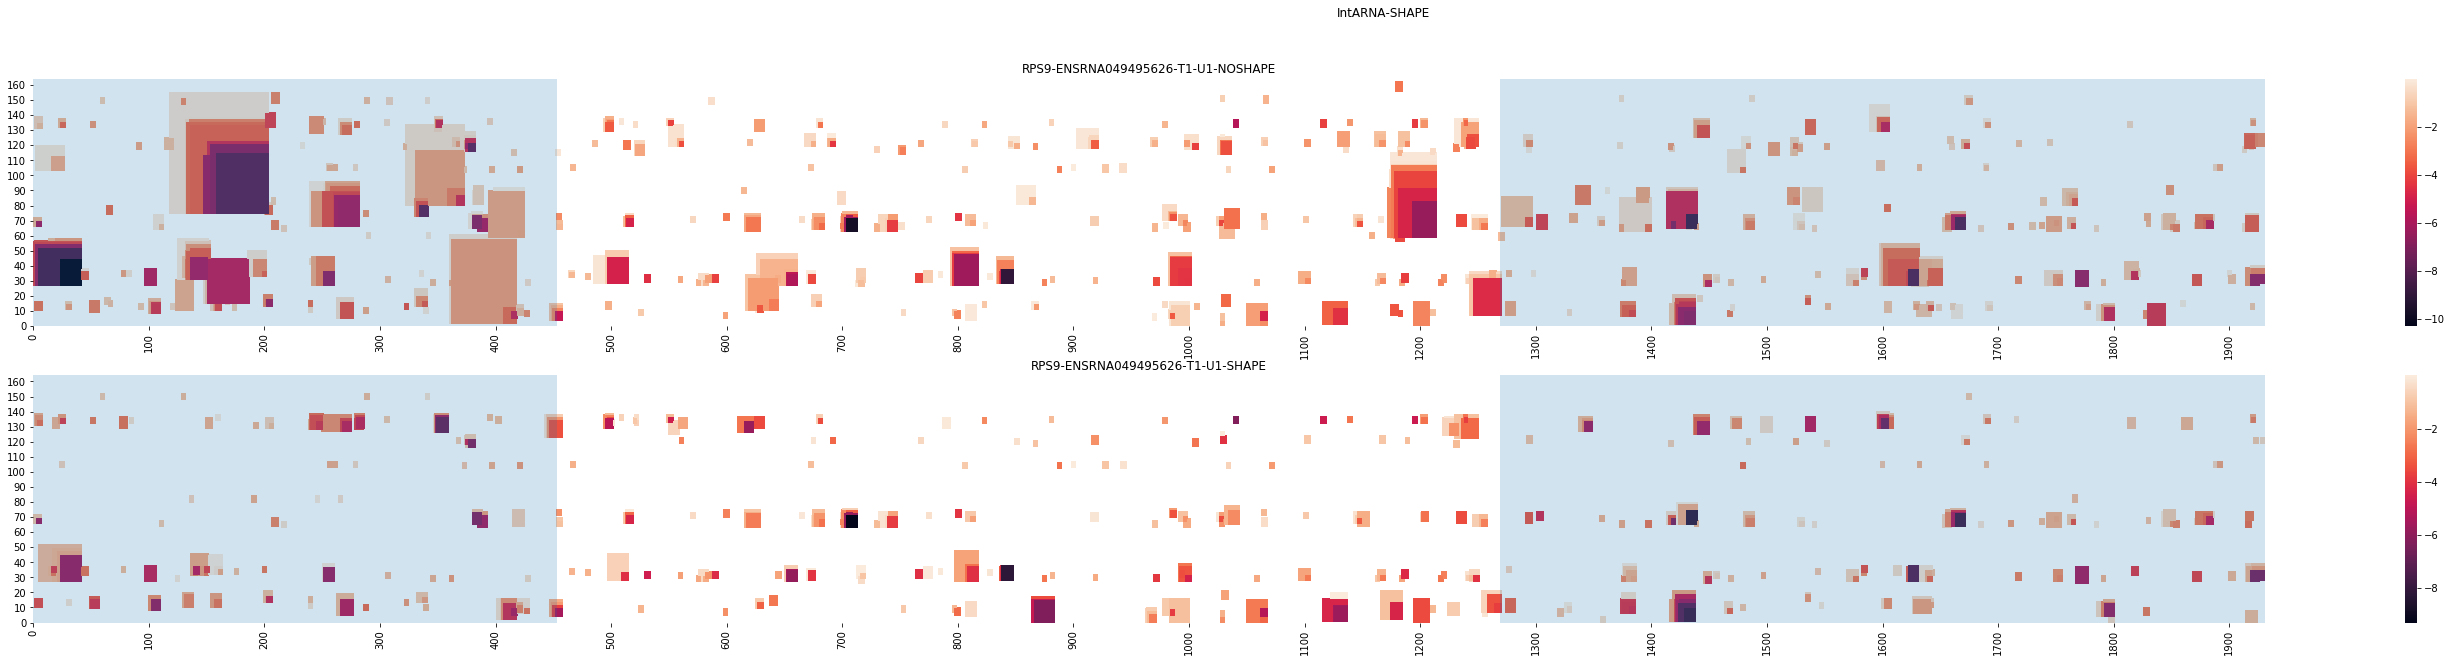

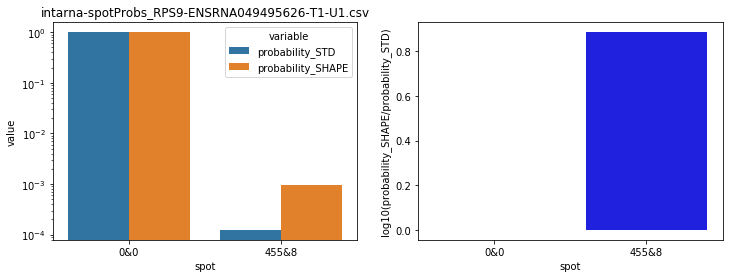

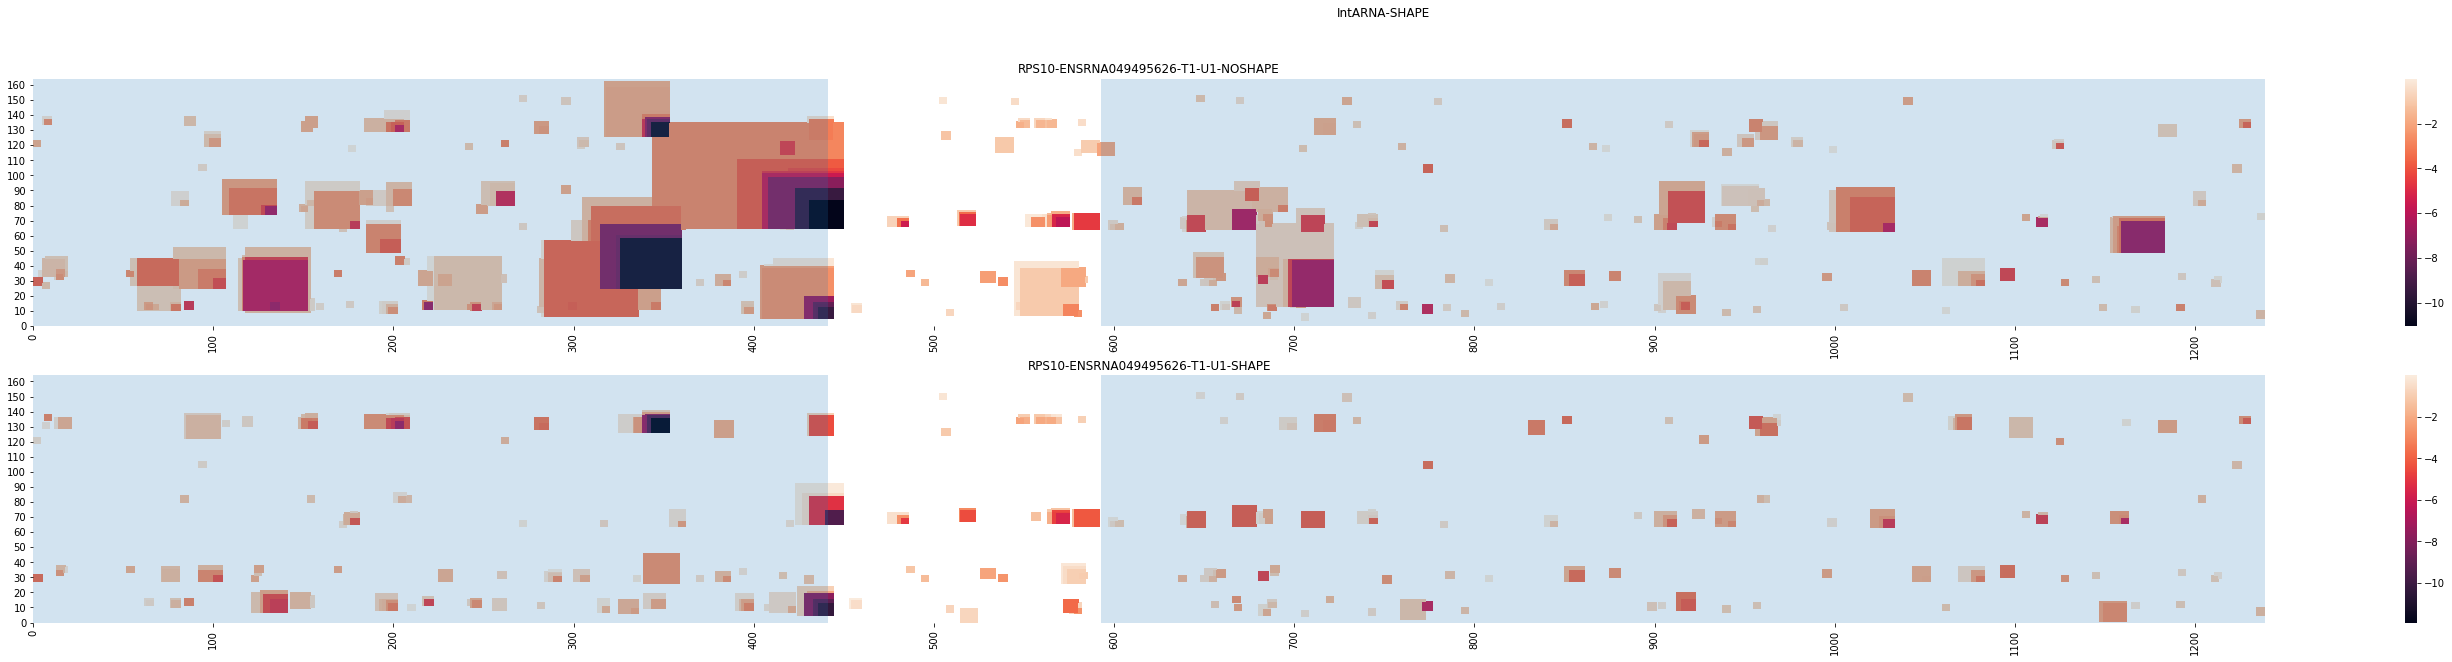

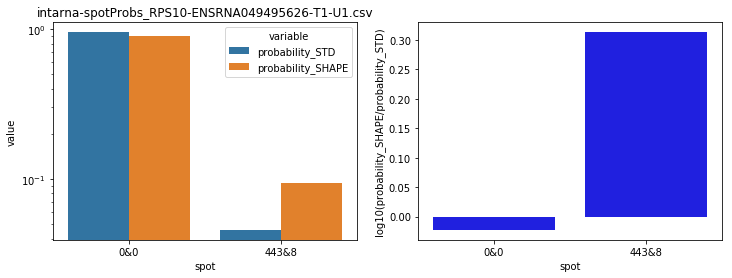

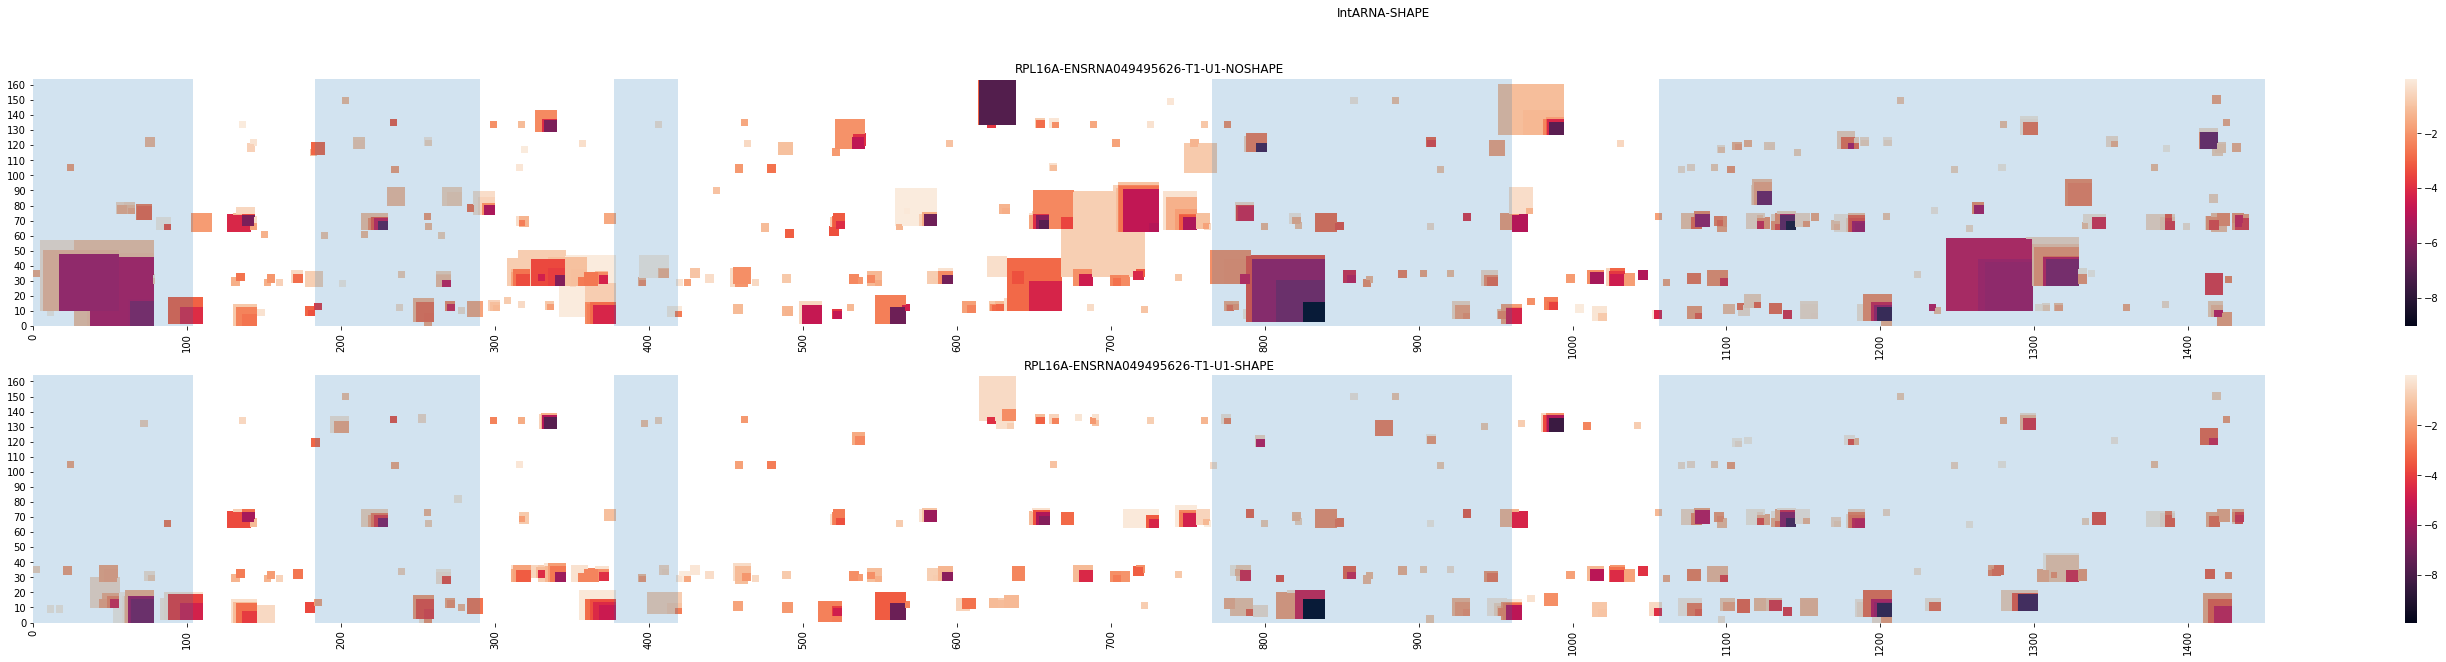

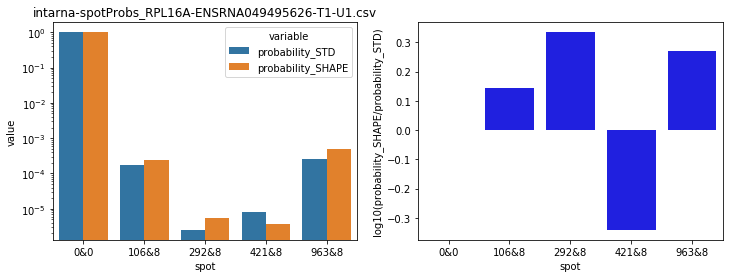

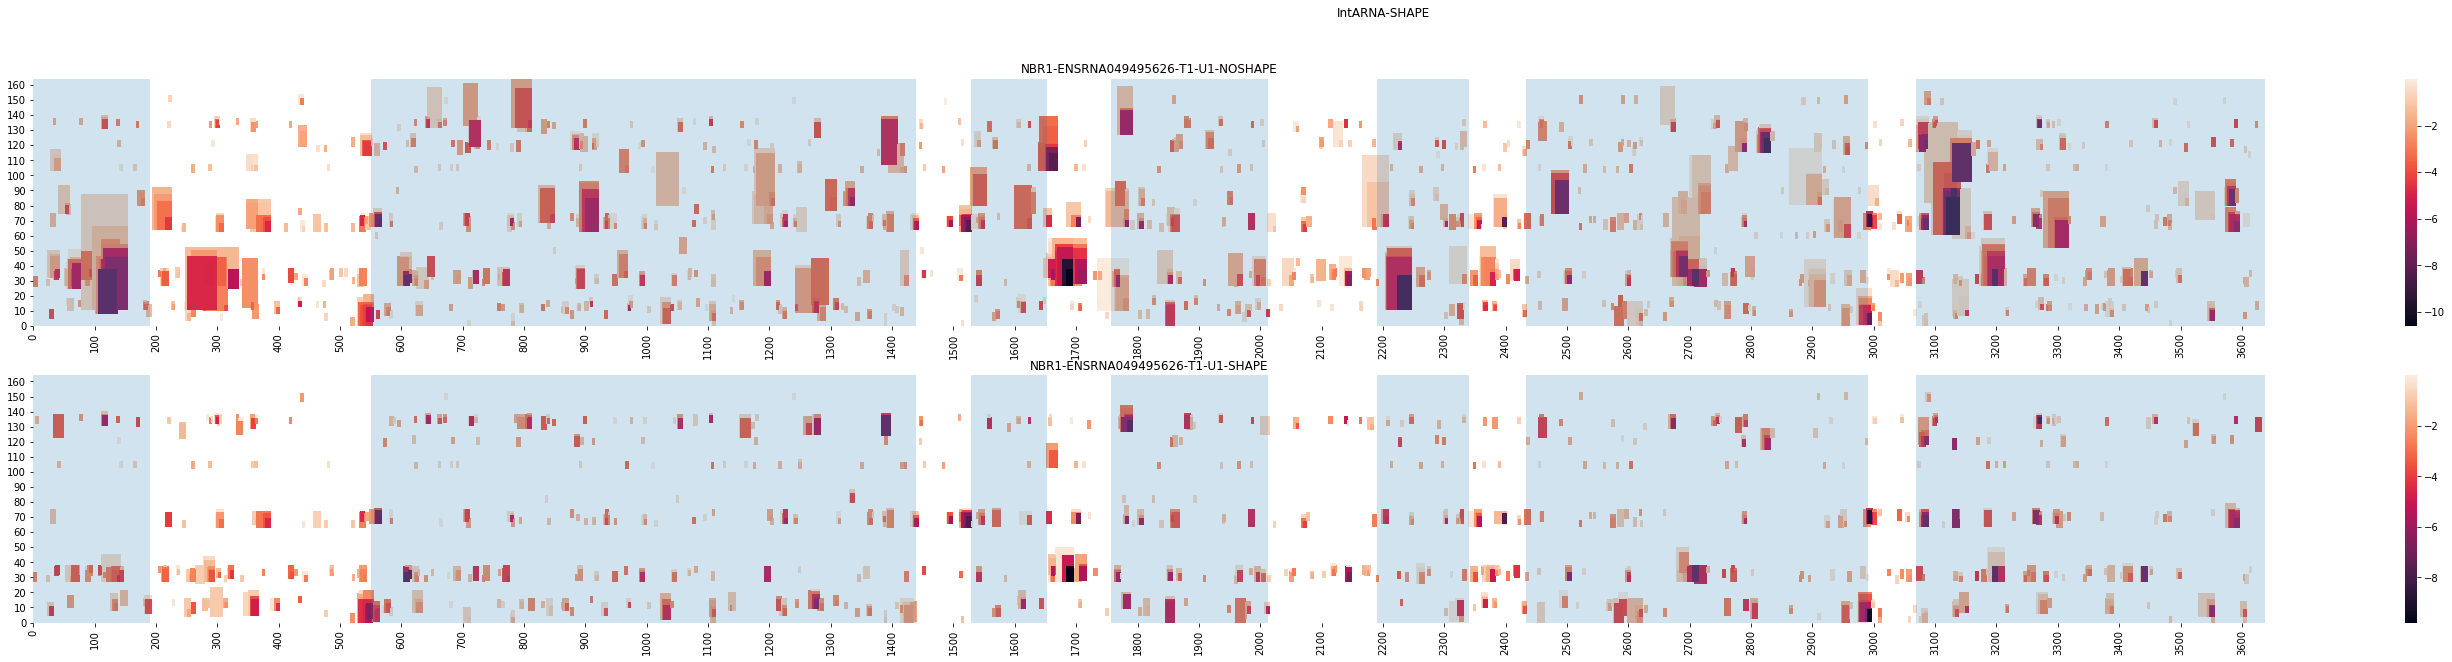

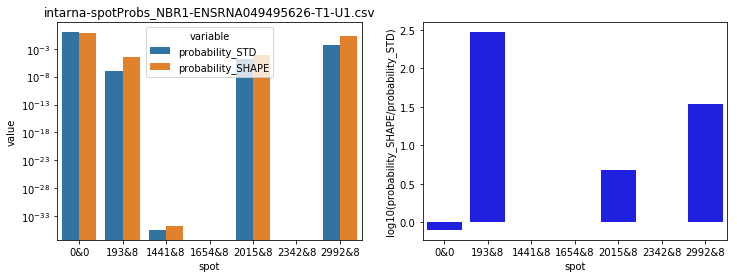

In [47]:
for gene in ['ACT1', 'RPS9', 'RPS10','RPL16A','NBR1',]:#'rps11','RPS11B',:
    run_intarna_shape_for_a_gene(gene)
    